In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

import healpy as hp
from tqdm import tqdm, tqdm_notebook
import scipy as sp
from scipy.special import erf
from scipy import stats

import sys
from my_units import * 

from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


'''plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors

rcParams['mathtext.rm'] = 'Computer Modern'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
'''

HomeDir = './'
DataDir = '/Users/crimondino/Dropbox (PI)/LensVelocity2/data/pairs_ruwe_dist/'#HomeDir #+ 'code/'
### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/hist_stats/'
FigDir = '../../../figures/'

In [39]:
from IPython.core.display import display, HTML
from IPython.display import display, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Read in cleaned sample

In [2]:
### Read in the data files for the background and foreground stars
df_back = pd.read_csv(DataDir+'bg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 
                                 'parallax', 'parallax_error', 'pmra_sub', 'pmdec_sub', 'phot_g_mean_mag', 'ruwe'])
df_fore = pd.read_csv(DataDir+'fg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ruwe'])
len(df_back), len(df_fore)

(10448136, 10448136)

In [3]:
### Read in the data files for the Bailer-Jones distances
back_dist = pd.read_csv(DataDir+'bg_distances.csv', usecols = ['0', '1', '2', '3'])
fore_dist = pd.read_csv(DataDir+'fg_distances.csv', usecols = ['0', '1', '2', '3'])
len(back_dist), len(fore_dist)

(10448136, 10448136)

In [4]:
df_back['dist_50'] = back_dist['1']
df_back['dist_14'] = back_dist['2']
df_back['dist_86'] = back_dist['3']

In [5]:
### Estimate of a symmetric error
df_back['dist_error'] = ((df_back['dist_50'].to_numpy() - df_back['dist_14'].to_numpy()) + 
                         (df_back['dist_86'].to_numpy() - df_back['dist_50'].to_numpy())) / 2

In [6]:
df_fore['dist_50'] = fore_dist['1']
df_fore['dist_14'] = fore_dist['2']
df_fore['dist_86'] = fore_dist['3']

## Import bin definitions

In [7]:
from bin_defs import *

hp.nside2npix(hp.order2nside(n)), len(bins_dist), len(bins_G), len(bins_bil)

(3072, 7, 18, 11)

In [10]:
(hp.nside2npix(hp.order2nside(n))-1) * (len(bins_dist)-1) * (len(bins_G)-1) * (len(bins_bil)-1)

3132420

## Function definition

In [8]:
def fn_pm_stats(df_fore, df_back, th_count=30, prob_sparse_th = 0.2, n_sigma_out = 3, final_call=False): ### if return_tab=True returns the tab without pm outliers, else returns the data frame with stats 

    # assign to healpix bins
    q_pix = np.floor(df_back['source_id'].to_numpy() / fac_source_id).astype(int)
    bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
    q_bin_pix = np.digitize(q_pix, bins_pix) - 1  # need to access the histogram matrix elements

    ### assign to G bins
    # assign to G bins
    bg_G = df_back['phot_g_mean_mag'].to_numpy()
    q_bin_G = np.digitize(bg_G, bins_G) - 1  

    # assign to radial bins
    ## necessary columns
    fg_ra = df_fore['ra'].to_numpy()
    fg_dec = df_fore['dec'].to_numpy()
    bg_ra = df_back['ra'].to_numpy()
    bg_dec = df_back['dec'].to_numpy()
    ## bil separation vectors
    l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    ## bin definitions
    q_bil = np.sqrt(l_bilnormsq)/arcsec
    q_bin_bil = np.digitize(q_bil, bins_bil) - 1   

    # probabilistic assignment to distance bins
    bg_dist = df_back['dist_50'].to_numpy()
    # bg error is average of posterior width in each direction
    bg_dist_error = df_back['dist_error'].to_numpy()
    
    prob_dist_neg = np.nan * np.ones((len(df_back),len(bins_dist_neg)-1))
    for i in range(len(bins_dist_neg)-1):
        x1_list = (bins_dist_neg[i]-bg_dist)/bg_dist_error/np.sqrt(2)
        x2_list = (bins_dist_neg[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
        prob_dist_neg[:,i] = 0.5*(erf(x2_list)-erf(x1_list))
    
    ### Add the probability in the negative distance bin to the first non negative bin
    prob_dist = np.nan * np.ones((len(df_back),len(bins_dist)-1))
    prob_dist = np.copy(prob_dist_neg[:, 1:])
    prob_dist[:, 0] += prob_dist_neg[:, 0]

    bg_pmra = df_back['pmra'].to_numpy(); bg_pmdec = df_back['pmdec'].to_numpy(); bg_parallax = df_back['parallax'].to_numpy();
    ### histogram of summed probabilities
    hist_prob = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix], np.transpose(prob_dist), bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] 
    ### histogram of average pmra weighted by probabilities
    hist_pmra = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmra, bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra = hist_pmra / (hist_prob + 1e-20) #then divide by number in each bin
    hist_pmdec = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmdec, bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] #sum first in each bin
    hist_pmdec = hist_pmdec / (hist_prob + 1e-20) #then divide by number in each bin
    ### histogram of average parallax weighted by probabilities
    hist_parallax = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_parallax, bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] #sum first in each bin
    hist_parallax = hist_parallax / (hist_prob + 1e-20) #then divide by number in each bin
    
    ### For each star, get the mean pm and parallax of the corresponding bin
    mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T
    mean_parallax = hist_parallax[:, q_bin_bil, q_bin_G, q_bin_pix].T

    ### histogram of pm variance weighted by dist bin probabilities
    hist_pmra_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra)**2,
                                                    bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra_var = hist_pmra_var / (hist_prob - 1 + 1e-20) # the estimator should have a -1 (this matches for example var() computed with panda's groupy)
    hist_pmdec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmdec.T - bg_pmdec)**2,
                                                    bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmdec_var = hist_pmdec_var / (hist_prob - 1 + 1e-20) 
    hist_pmradec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra) * (mean_pmdec.T - bg_pmdec),
                                                        bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmradec_var = hist_pmradec_var / (hist_prob - 1 + 1e-20) 
    hist_parallax_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_parallax.T - bg_parallax)**2, 
                                                     bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_parallax_var = hist_parallax_var / (hist_prob - 1 + 1e-20) 
    
    ### set to nan bins where there are too few stars
    hist_pmra[hist_prob < th_count] = np.nan; hist_pmdec[hist_prob < th_count] = np.nan; hist_parallax[hist_prob < th_count] = np.nan
    hist_pmra_var[hist_prob < th_count] = np.nan; hist_pmdec_var[hist_prob < th_count] = np.nan; hist_pmradec_var[hist_prob < th_count] = np.nan
    hist_parallax_var[hist_prob < th_count] = np.nan

    ### For each star, get the pm mean and variance of the corresponding bin (after excluding the low count bins)
    mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T
    mean_parallax = hist_parallax[:, q_bin_bil, q_bin_G, q_bin_pix].T
    var_pmra = hist_pmra_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmdec = hist_pmdec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmradec = hist_pmradec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T;    
    var_parallax = hist_parallax_var[:, q_bin_bil, q_bin_G, q_bin_pix].T
    
    ###  Get the mean and var for each star
    tab_sum_pw = np.sum(prob_dist, axis=1, where=(~np.isnan(mean_pmra)))  # sum of the dist weights for each star using only bins with enough statistics 
    tab_mean_pmra = np.sum(np.nan_to_num(mean_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_mean_pmdec = np.sum(np.nan_to_num(mean_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_mean_parallax = np.sum(np.nan_to_num(mean_parallax*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_var_pmra = np.sum(np.nan_to_num(var_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_var_pmdec = np.sum(np.nan_to_num(var_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_var_pmradec = np.sum(np.nan_to_num(var_pmradec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)   
    tab_var_parallax = np.sum(np.nan_to_num(var_parallax*prob_dist), axis=1)/(tab_sum_pw + 1e-20)   
    
    ### Find all the stars whose distance probability support is mostly in spare bins. Remove stars with more than 20% probability in sparse bins
    hist_prob_copy = np.copy(hist_prob)
    hist_prob_copy[hist_prob<th_count] = 1
    hist_prob_copy[hist_prob>=th_count] = 0
    count_prob_sparse = hist_prob_copy[:, q_bin_bil, q_bin_G, q_bin_pix].T

    prob_in_sparse_bin = np.sum(count_prob_sparse*prob_dist, axis=1)
    good_bins = prob_in_sparse_bin < prob_sparse_th
    
    len_bg = len(df_back)
    out_frac=(1-len(prob_in_sparse_bin[good_bins])/len_bg);        
    print('Iter '+str(iter_n)+' -- fraction of stars in sparse bins: '+str(out_frac*100)[:8]+' %')
    
    tab_mean_pmra = tab_mean_pmra[good_bins]; tab_mean_pmdec = tab_mean_pmdec[good_bins]; tab_mean_parallax = tab_mean_parallax[good_bins]
    tab_var_pmra = tab_var_pmra[good_bins]; tab_var_pmdec = tab_var_pmdec[good_bins]; tab_var_pmradec = tab_var_pmradec[good_bins]
    tab_var_parallax = tab_var_parallax[good_bins]
    
    df_fore = df_fore.iloc[good_bins]; df_back = df_back.iloc[good_bins]
    
    ### subtracted pm and inverse covariance for outlier removal
    pm_sub = np.array([df_back['pmra'].to_numpy()-tab_mean_pmra, df_back['pmdec'].to_numpy()-tab_mean_pmdec]).T
    parallax_sub = df_back['parallax'].to_numpy()-tab_mean_parallax

    if final_call==False: ### remove outliers
        inv_cov_pm = np.linalg.inv(np.array([[tab_var_pmra, tab_var_pmradec], [tab_var_pmradec, tab_var_pmdec]]).T)
        mu_over_sigma_sq = inv_cov_pm[:, 0, 0]*pm_sub[:, 0]**2 + inv_cov_pm[:, 1, 1]*pm_sub[:, 1]**2 + 2*inv_cov_pm[:, 0, 1]*pm_sub[:, 0]*pm_sub[:, 1]

        len_bg = len(df_back)
        df_fore = df_fore.iloc[( (mu_over_sigma_sq < n_sigma_out**2) & (parallax_sub**2/tab_var_parallax < n_sigma_out**2) )]
        df_back = df_back.iloc[( (mu_over_sigma_sq < n_sigma_out**2) & (parallax_sub**2/tab_var_parallax < n_sigma_out**2) )]
        out_frac=(1-len(df_back)/len_bg);        
        print('Iter '+str(iter_n)+' -- fraction of outliers removed: '+str(out_frac*100)[:8]+' %')
        
        return df_fore, df_back
            
    else: ### add columns corresponding to subtracted pm motion and effective variance 
        df_back['pmra_sub_new'] = pm_sub[:, 0]; df_back['pmdec_sub_new'] = pm_sub[:, 1]; df_back['parallax_sub_new'] = parallax_sub
        
        df_back['pmra_eff_error_new'] = np.sqrt(tab_var_pmra)
        df_back['pmdec_eff_error_new'] = np.sqrt(tab_var_pmdec)

        df_back['pmra_pmdec_eff_corr_new'] = tab_var_pmradec/(np.sqrt(tab_var_pmra)*np.sqrt(tab_var_pmdec))
        
        df_back['parallax_eff_error_new'] = np.sqrt(tab_var_parallax)
        
        return df_fore, df_back

## Run

In [9]:
iter_n=0
out_frac=1
n_iter = 10 # each iteration around 1 minutes
n_sigma_out = 3
th_count = 30
prob_sparse_th = 0.2

while (iter_n<n_iter) & (out_frac>1E-5):
    df_fore_n, df_back_n = fn_pm_stats(df_fore, df_back, th_count, prob_sparse_th, n_sigma_out, final_call=False)
    df_fore, df_back = df_fore_n, df_back_n
    iter_n += 1; 

Iter 0 -- fraction of stars in sparse bins: 19.88473 %
Iter 0 -- fraction of outliers removed: 3.320342 %
Iter 1 -- fraction of stars in sparse bins: 3.706228 %
Iter 1 -- fraction of outliers removed: 2.335316 %
Iter 2 -- fraction of stars in sparse bins: 1.124508 %
Iter 2 -- fraction of outliers removed: 1.110652 %
Iter 3 -- fraction of stars in sparse bins: 0.266194 %
Iter 3 -- fraction of outliers removed: 0.507900 %
Iter 4 -- fraction of stars in sparse bins: 0.093377 %
Iter 4 -- fraction of outliers removed: 0.231837 %
Iter 5 -- fraction of stars in sparse bins: 0.051793 %
Iter 5 -- fraction of outliers removed: 0.107935 %
Iter 6 -- fraction of stars in sparse bins: 0.018398 %
Iter 6 -- fraction of outliers removed: 0.050878 %
Iter 7 -- fraction of stars in sparse bins: 0.006809 %
Iter 7 -- fraction of outliers removed: 0.024119 %
Iter 8 -- fraction of stars in sparse bins: 0.002778 %
Iter 8 -- fraction of outliers removed: 0.011987 %
Iter 9 -- fraction of stars in sparse bins: 0.

In [10]:
### Do the subtraction one last time without removing the outliers
df_fore_n, df_back_n = fn_pm_stats(df_fore, df_back, th_count, prob_sparse_th, n_sigma_out, final_call=True)
df_fore, df_back = df_fore_n, df_back_n

Iter 10 -- fraction of stars in sparse bins: 0.001594 %


<ipython-input-8-cd57858cf411>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back['pmra_sub_new'] = pm_sub[:, 0]; df_back['pmdec_sub_new'] = pm_sub[:, 1]; df_back['parallax_sub_new'] = parallax_sub
<ipython-input-8-cd57858cf411>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back['pmra_eff_error_new'] = np.sqrt(tab_var_pmra)
<ipython-input-8-cd57858cf411>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [41]:
### Save the result

df_fore.to_csv(DataDir+'fg_subtracted.csv', index=False, chunksize=100000)

In [42]:
df_back.to_csv(DataDir+'bg_subtracted.csv', index=False, chunksize=100000)

## Plots

Text(0.5, 0.98, 'New Subtraction')

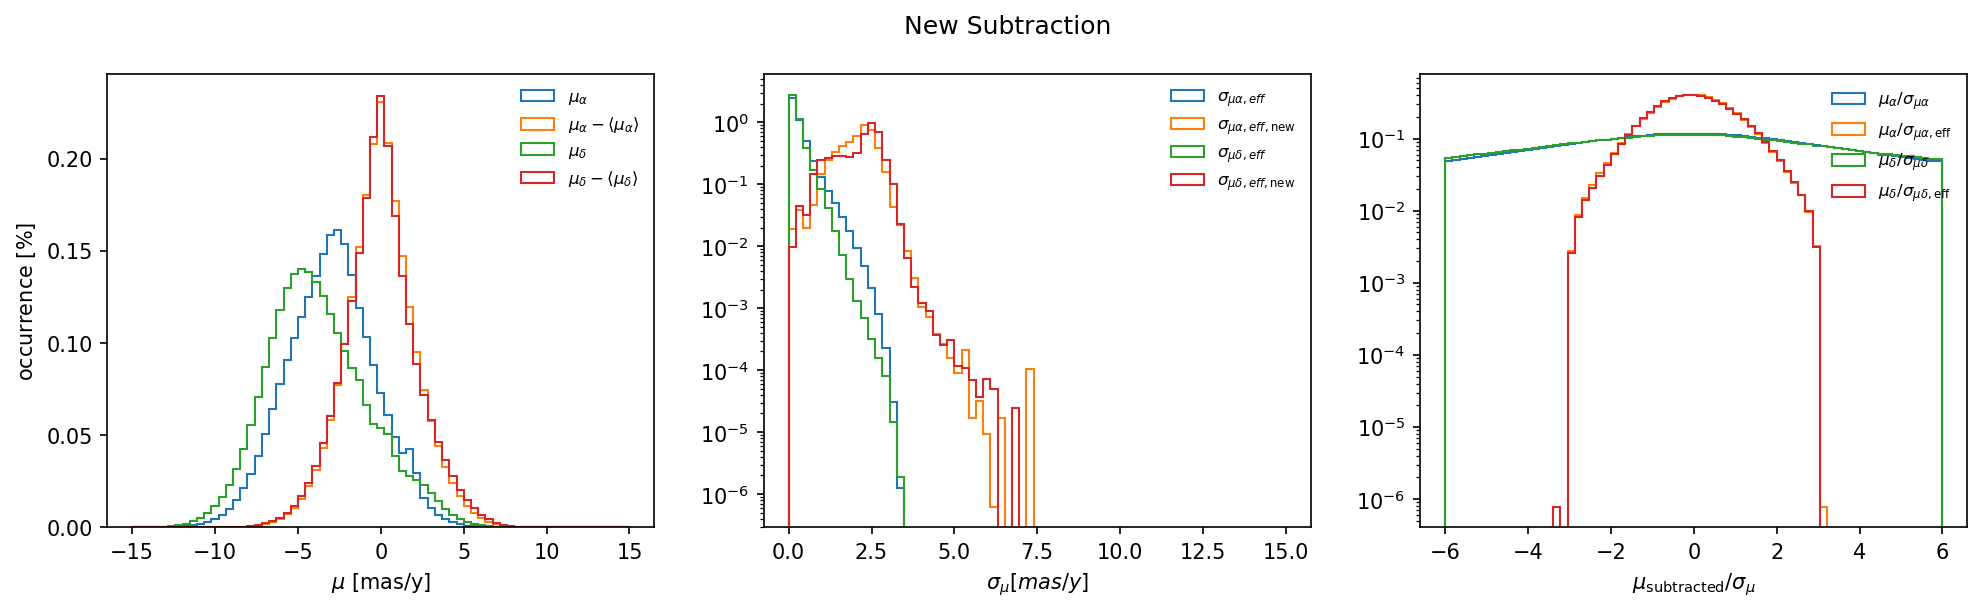

In [13]:
fig,ax = plt.subplots(1,3,figsize=(16,4), dpi = 150)

xmax, nbins = 15, 70
ax[0].hist(df_back['pmra'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['pmra_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['pmdec'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['pmdec_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\mu_\alpha$', r'$\mu_\alpha - \langle \mu_\alpha \rangle$', '$\mu_\delta$', r'$\mu_\delta - \langle \mu_\delta \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\mu$ [mas/y]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 15, 70
ax[1].hist(df_back['pmra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['pmra_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['pmdec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['pmdec_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
#ax[1].set_ylim(0.001, 3)

#ax[1].legend([r'$\sigma_{\mu\alpha, \mathrm{Gaia}}$', r'$\sigma_{\mu\alpha, eff, \mathrm{new}}$', r'$\sigma_{\mu\delta, \mathrm{Gaia}}$', r'$\sigma_{\mu\delta, eff, \mathrm{new}}$'], 
#             loc='upper right', fontsize = 8, frameon=False);
ax[1].legend([r'$\sigma_{\mu\alpha, eff}$', r'$\sigma_{\mu\alpha, eff, \mathrm{new}}$', 
              r'$\sigma_{\mu\delta, eff}$', r'$\sigma_{\mu\delta, eff, \mathrm{new}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\mu [mas/y]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 6, 70
ax[2].hist(df_back['pmra_sub_new']/df_back['pmra_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['pmra_sub_new']/df_back['pmra_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['pmdec_sub_new']/df_back['pmdec_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['pmdec_sub_new']/df_back['pmdec_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\mu_{\alpha}/\sigma_{\mu\alpha}$', r'$\mu_{\alpha}/\sigma_{\mu\alpha, \mathrm{eff}}$', 
              r'$\mu_{\delta}/\sigma_{\mu\delta}$', r'$\mu_{\delta}/\sigma_{\mu\delta, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel(r'occurrence [$\%$]');

#plt.tight_layout()
plt.suptitle('New Subtraction')
#fig.savefig(FigDir+'pm_stats.pdf')

Text(0.5, 0.98, 'New Subtraction')

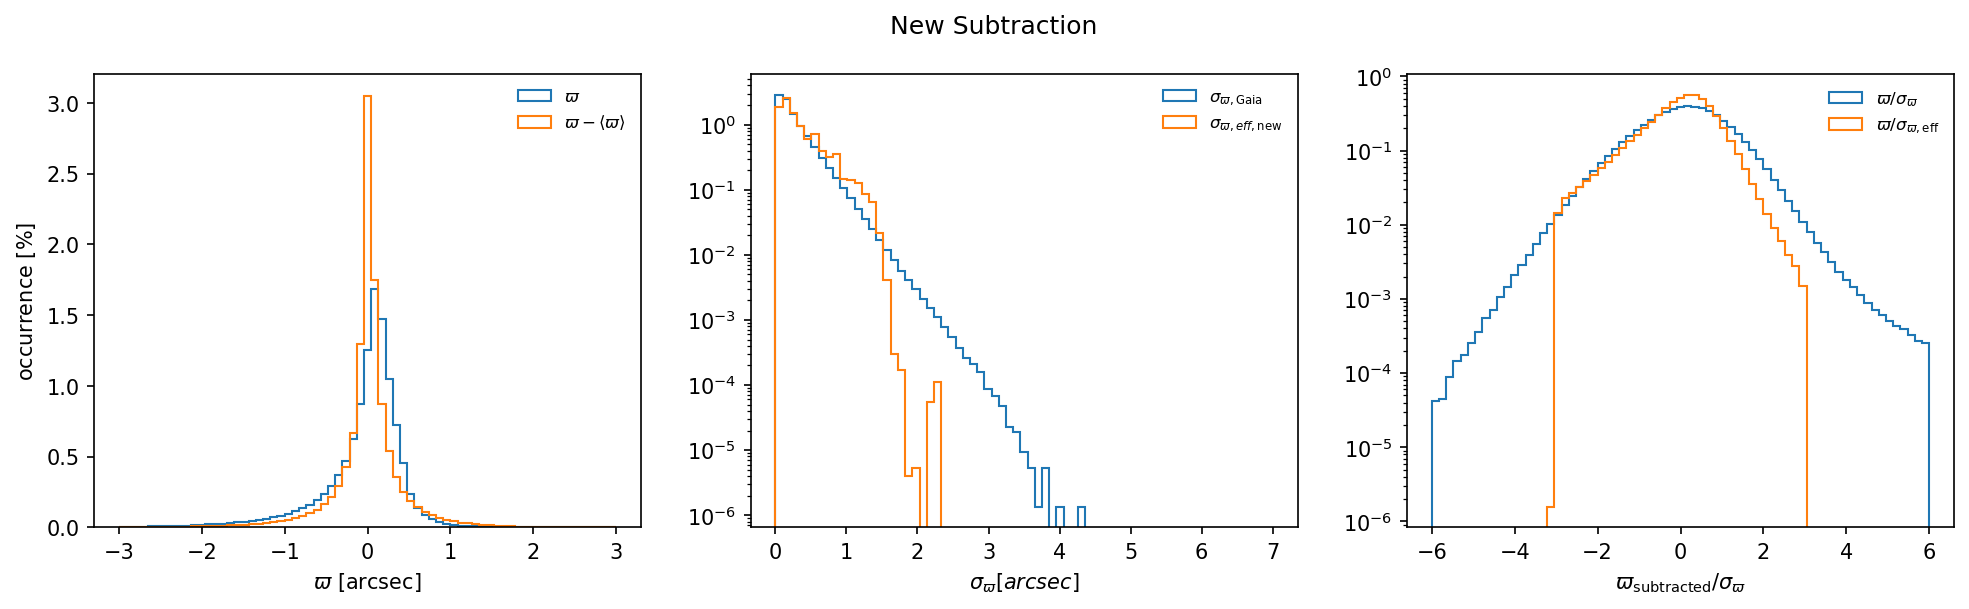

In [17]:
fig,ax = plt.subplots(1,3,figsize=(16,4), dpi = 150)

xmax, nbins = 3, 70
ax[0].hist(df_back['parallax'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['parallax_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\varpi$', r'$\varpi - \langle \varpi \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\varpi$ [arcsec]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 7, 70
ax[1].hist(df_back['parallax_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['parallax_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\varpi, \mathrm{Gaia}}$', r'$\sigma_{\varpi, eff, \mathrm{new}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\varpi [arcsec]$'); 

xmax, nbins = 6, 70
ax[2].hist(df_back['parallax_sub_new']/df_back['parallax_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['parallax_sub_new']/df_back['parallax_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\varpi/\sigma_{\varpi}$', r'$\varpi/\sigma_{\varpi, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\varpi_\mathrm{subtracted}/\sigma_\varpi$'); 

#plt.tight_layout()
plt.suptitle('New Subtraction')
#fig.savefig(FigDir+'pm_stats.pdf')

In [18]:
## covariance matrix with the new effective variances
def fn_cov_pm_eff(df):
    """
    Given a panda data frame df, returns the effective covariance matrix for (pmra, pmdec).
    """
    return np.array([[df['pmra_eff_error_new']**2, df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new']], 
                     [df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new'], df['pmdec_eff_error_new']**2]]).T

In [19]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))
pm_sub = np.array([df_back['pmra_sub_new'].to_numpy(), df_back['pmdec_sub_new'].to_numpy()]).T

mu_over_sigma_sq = (inv_cov_pm[:, 0, 0]*pm_sub[:, 0]**2 + inv_cov_pm[:, 1, 1]*pm_sub[:, 1]**2 + 
                    2*inv_cov_pm[:, 0, 1]*pm_sub[:, 0]*pm_sub[:, 1])